In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iam-handwriting-top50/forms_for_parsing.txt
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/b06-093-s01-05.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/c03-087c-s01-00.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/c03-084c-s00-02.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/c06-087-s00-04.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/h06-003-s02-02.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/g06-050i-s01-01.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/h06-089-s00-03.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/g06-026g-s02-00.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/g06-011m-s03-01.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/g06-026e-s02-00.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/p06-069-s01-02.png
/kaggle/input/iam-handwriting-top50/data_subset/data_subset/g06-050

In [14]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

In [15]:
d = {}
from subprocess import check_output
with open('../input/iam-handwriting-top50/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

1539


In [16]:
tmp = []
target_list = []

path_to_files = os.path.join('../input/iam-handwriting-top50/data_subset/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


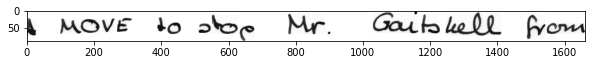

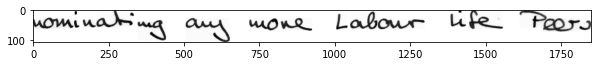

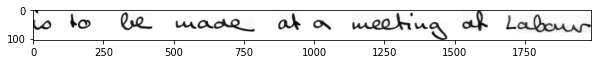

In [17]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [18]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['../input/iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-00.png'
 '../input/iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-01.png'
 '../input/iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-02.png'
 '../input/iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-03.png'
 '../input/iam-handwriting-top50/data_subset/data_subset/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [19]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [20]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     'data/train',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='binary')

# validation_generator = test_datagen.flow_from_directory(
#     'data/validation',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='binary')

# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 8 #16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train), shuffle(y_train)

In [21]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [22]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 64)       

In [24]:
nb_epoch = 8

samples_per_epoch = 3268
nb_val_samples = 842

# #save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
#filepath="check-{epoch:02d}-{val_loss:.4f}.hdf5"
filepath="weights.{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# #Model fit generator
history_object = model.fit(train_generator, steps_per_epoch = samples_per_epoch//batch_size,
                                      validation_data=validation_generator,
                                      validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)

Epoch 1/8
408/408 [==============================] - 2166s 5s/step - loss: 3.6961 - accuracy: 0.2062 - val_loss: 3.5626 - val_accuracy: 0.2176

Epoch 00001: saving model to weights.01-3.5626.hdf5
Epoch 2/8
408/408 [==============================] - 2138s 5s/step - loss: 3.5854 - accuracy: 0.2114 - val_loss: 3.5442 - val_accuracy: 0.2179

Epoch 00002: saving model to weights.02-3.5442.hdf5
Epoch 3/8
408/408 [==============================] - 2146s 5s/step - loss: 3.5723 - accuracy: 0.2131 - val_loss: 3.5411 - val_accuracy: 0.2178

Epoch 00003: saving model to weights.03-3.5411.hdf5
Epoch 4/8
408/408 [==============================] - 2123s 5s/step - loss: 3.5686 - accuracy: 0.2149 - val_loss: 3.5360 - val_accuracy: 0.2187

Epoch 00004: saving model to weights.04-3.5360.hdf5
Epoch 5/8
408/408 [==============================] - 2128s 5s/step - loss: 3.5690 - accuracy: 0.2135 - val_loss: 3.5342 - val_accuracy: 0.2181

Epoch 00005: saving model to weights.05-3.5342.hdf5
Epoch 6/8
408/408 [=

In [ ]:
model.load_weights('weights.08-3.5295.hdf5')
scores = model.evaluate(test_generator) 
print("Accuracy = ", scores[1])

   4390/Unknown - 1596s 364ms/step - loss: 3.4670 - accuracy: 0.2548